In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/data/figs/'
metadata = '/home/chantal/Chazy/data/Metadata_515806_all.txt'

nprocs = 20

In [3]:
%%R
library(ggplot2)
library(doParallel)
library(gridExtra)
library(data.table)
library(vegan)
library(plyr)
library(RColorBrewer)
library(stats)
library(stringr)
library(dplyr)
library(jsonlite)
library(RJSONIO)
library(scales)
library(tidyr)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: foreach

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: data.table 1.9.6  For help type 

In [4]:
%%R
meta = read.csv(metadata, sep = '\t', header = TRUE)

In [5]:
%%R
bulk = filter(meta, Experiment == 'Chazy_Bulk_515806', !(is.na(Month)), Land_Management != "PAS")
head(bulk)

       Full.sample Fraction PrimerF PrimerR Barcode Rev.index Fwd.index
1 April.NTR.3.2015       NA    515f    806r      94  tatagcga  cgtgagtg
2    April15.NTH.1       NA    515f    806r      63  cgagcgac  ggatatct
3    April15.NTH.2       NA    515f    806r      67  actacgac  tagcgagt
4    April15.NTH.3       NA    515f    806r      71  actacgac  ggatatct
5    April15.NTH.4       NA    515f    806r      75  gtctgcta  tagcgagt
6    April15.NTR.1       NA    515f    806r      65  actacgac  atcgtacg
  Treatment Day Replicate Pool Land_Management Gradient        Experiment Month
1      <NA>  NA        NA    8             NTR     <NA> Chazy_Bulk_515806 April
2      <NA>  NA         1    4             NTH     <NA> Chazy_Bulk_515806 April
3      <NA>  NA         2    4             NTH     <NA> Chazy_Bulk_515806 April
4      <NA>  NA         3    4             NTH     <NA> Chazy_Bulk_515806 April
5      <NA>  NA         4    4             NTH     <NA> Chazy_Bulk_515806 April
6      <NA>  NA 

In [6]:
%%R
bulk$day = 1
bulk$date = paste(bulk$Year, bulk$Month, bulk$day,sep="-")

bulk$date = as.POSIXct(strptime(bulk$date,format="%Y-%B-%d"))


In [7]:
%%R
head(bulk$date)

[1] "2015-04-01 MDT" "2015-04-01 MDT" "2015-04-01 MDT" "2015-04-01 MDT"
[5] "2015-04-01 MDT" "2015-04-01 MDT"


In [8]:
%%R
bulk = bulk %>% arrange(Sample_Date, Land_Management, Replicate)

In [9]:
%%R
a = aov(bulk$Soil_Temp ~bulk$Land_Management + bulk$Replicate + bulk$Sample_Date)
summary(a)

                      Df Sum Sq Mean Sq  F value Pr(>F)    
bulk$Land_Management   3      1     0.5    0.904  0.442    
bulk$Replicate         1      0     0.2    0.322  0.572    
bulk$Sample_Date       7   7758  1108.2 2032.817 <2e-16 ***
Residuals            115     63     0.5                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
49 observations deleted due to missingness


In [10]:
%%R
a = aov(bulk$Soil_Moisture ~bulk$OM + bulk$Replicate)
summary(a)

                Df Sum Sq Mean Sq F value Pr(>F)
bulk$OM          1     26   26.05   0.837  0.362
bulk$Replicate   1     59   59.06   1.899  0.170
Residuals      156   4852   31.11               
17 observations deleted due to missingness


In [11]:
%%R
head(bulk)
bulk %>% group_by(Land_Management) %>% filter(!(is.na(Soil_Moisture))) %>% summarise(meanSoilM = mean(Soil_Moisture),
                                                                                    sdSoilM = sd(Soil_Moisture))

Source: local data frame [4 x 3]

  Land_Management meanSoilM  sdSoilM
           (fctr)     (dbl)    (dbl)
1             NTH  17.14583 3.075996
2             NTR  16.54333 2.474326
3             PTH  17.41667 8.192029
4             PTR  16.48500 6.595107


In [12]:
%%R

sumdata = bulk %>% group_by(Land_Management, date) %>%   
  summarise(
          count = n(),
          mean_Soil_Temp = mean(Soil_Temp, na.rm=TRUE),
          stdev_Soil_Temp = sd(Soil_Temp, na.rm=TRUE), #/ sqrt(n())
          stderr_Soil_Temp = sd(Soil_Temp, na.rm=TRUE) / sqrt(count),
          ymin_Soil_Temp = mean_Soil_Temp - stdev_Soil_Temp,
          ymax_Soil_Temp = mean_Soil_Temp + stdev_Soil_Temp,
          mean_Soil_M = mean(Soil_Moisture, na.rm=TRUE),
          stdev_Soil_M = sd(Soil_Moisture, na.rm=TRUE), #/ sqrt(n())
          stderr_Soil_M = sd(Soil_Moisture, na.rm=TRUE) / sqrt(count),
          ymin_Soil_M = mean_Soil_M - stdev_Soil_M,
          ymax_Soil_M = mean_Soil_M + stdev_Soil_M
          )

In [13]:
%%R
sumdata = arrange(sumdata, Land_Management, date)

In [14]:
%%R

times = c('2014-7-10', '2014-9-24','2014-10-29','2014-11-26','2015-4-30','2015-6-17','2015-7-16',
               '2015-8-13','2015-9-23', '2015-10-27', '2015-11-25', '2014-7-10', '2014-9-24','2014-10-29','2014-11-26','2015-4-30','2015-6-17','2015-7-16',
               '2015-8-13','2015-9-23', '2015-10-27', '2015-11-25', '2014-7-10', '2014-9-24','2014-10-29','2014-11-26','2015-4-30','2015-6-17','2015-7-16',
               '2015-8-13','2015-9-23', '2015-10-27', '2015-11-25', '2014-7-10', '2014-9-24','2014-10-29','2014-11-26','2015-4-30','2015-6-17','2015-7-16',
               '2015-8-13','2015-9-23', '2015-10-27', '2015-11-25')
sumdata$realdate = as.POSIXct(strptime(times, format = "%Y-%m-%d"))


In [15]:
%%R
head(sumdata)

Source: local data frame [6 x 14]
Groups: Land_Management [1]

  Land_Management       date count mean_Soil_Temp stdev_Soil_Temp
           (fctr)     (time) (int)          (dbl)           (dbl)
1             NTH 2014-07-01     4            NaN             NaN
2             NTH 2014-09-01     4       15.53333       0.3858612
3             NTH 2014-10-01     4            NaN             NaN
4             NTH 2014-11-01     4        2.75000       0.1290994
5             NTH 2015-04-01     4       13.00833       0.3510566
6             NTH 2015-06-01     4       20.75000       0.3316625
Variables not shown: stderr_Soil_Temp (dbl), ymin_Soil_Temp (dbl),
  ymax_Soil_Temp (dbl), mean_Soil_M (dbl), stdev_Soil_M (dbl), stderr_Soil_M
  (dbl), ymin_Soil_M (dbl), ymax_Soil_M (dbl), realdate (time)


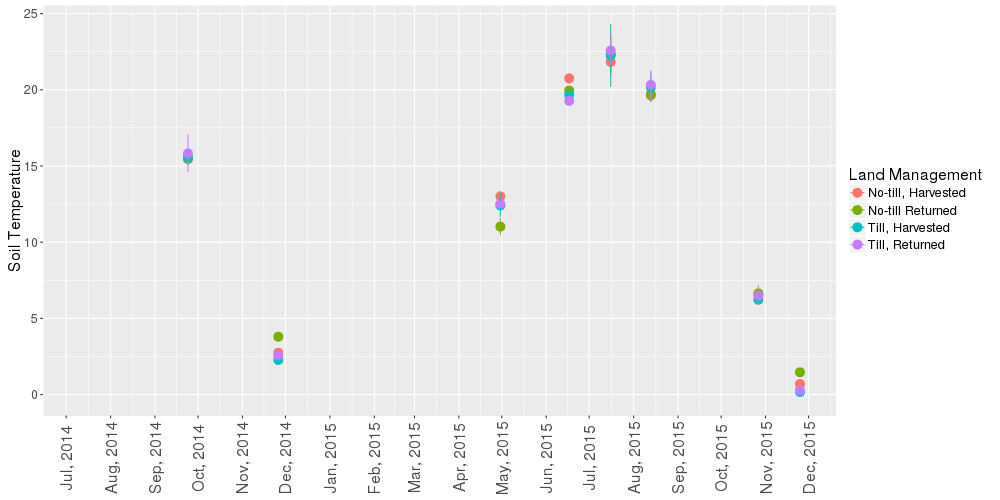

In [16]:
%%R -w 1000 -h 500
p = ggplot(sumdata, aes(realdate, mean_Soil_Temp, color=Land_Management)) +
  geom_point(size = 4) + geom_errorbar(aes(ymin = ymin_Soil_Temp, ymax = ymax_Soil_Temp), width = 0.2) +
    theme(
    text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.5, size=16), legend.justification = "center") +
    xlab(NULL) + ylab("Soil Temperature") +
    scale_x_datetime(breaks = date_breaks("1 month"), labels=date_format("%b, %Y")) +
    scale_y_continuous(breaks=seq(0, 50, 5)) + scale_color_discrete(name = 'Land Management', 
                                                                    labels = c('No-till, Harvested', 'No-till Returned',
                                                                              'Till, Harvested', 'Till, Returned')) 
  
p
p

In [53]:
%%R
ggsave(filename = "data/figs/Soil_Temp.png", plot = p, width =9, height =5)

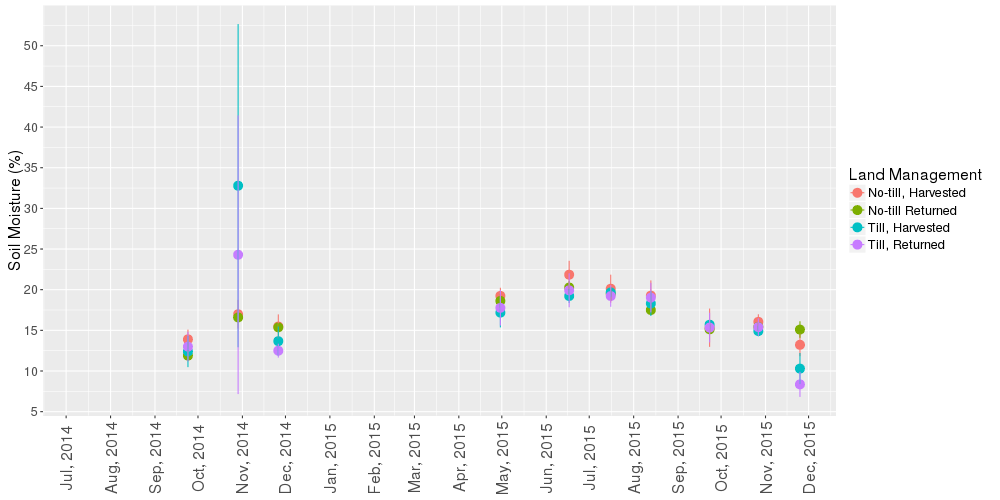

In [54]:
%%R -w 1000 -h 500
p = ggplot(sumdata, aes(realdate, mean_Soil_M, group=Land_Management, color=Land_Management)) +
  geom_point(size = 4) + geom_errorbar(aes(ymin = ymin_Soil_M, ymax = ymax_Soil_M), width = 0.2) +
    theme(
    text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.5, size=16), legend.justification = "center") +
    xlab(NULL) + ylab("Soil Moisture (%)") +
    scale_x_datetime(breaks = date_breaks("1 month"), labels=date_format("%b, %Y")) +
    scale_y_continuous(breaks=seq(0, 50, 5)) + scale_color_discrete(name = 'Land Management', 
                                                                    labels = c('No-till, Harvested', 'No-till Returned',
                                                                              'Till, Harvested', 'Till, Returned'))
  
p

In [55]:
%%R
ggsave(filename = "data/figs/Soil_Moist.png", plot = p, width =8, height =6)

In [56]:
%%R
#NOAA = read.csv('data/NOAA_Chazy.csv', header = TRUE)

NULL


In [17]:
%%R
NOAA2Year = read.csv('/home/chantal/Chazy/data/Two_Year_Climate.csv')

In [18]:
%%R
head(NOAA2Year)

            STATION                            STATION_NAME     DATE MDPR DAPR
1 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140101   NA   NA
2 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140102   NA   NA
3 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140103   NA   NA
4 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140104   NA   NA
5 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140105   NA   NA
6 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140106   NA   NA
  PRCP SNWD SNOW  TMAX  TMIN TOBS WESD WESF WT09 WT01 WT06 WT02 WT08 WT03
1  0.0    0   NA  -9.3 -21.0   NA   NA   NA   NA   NA   NA   NA   NA   NA
2  0.0    0   NA -21.0 -24.9   NA   NA   NA   NA   NA   NA   NA    1   NA
3  0.0    0   NA -18.2 -28.2   NA   NA   NA   NA   NA   NA   NA    1   NA
4  0.0    0    0  -6.0 -28.2   NA   NA   NA   NA   NA   NA   NA   NA   NA
5  1.3    0   NA  -0.5  -9.3   NA   NA   NA   NA    1    1   NA   NA   NA
6  

In [19]:
%%R
NOAA2Year$d = as.POSIXct(strptime(NOAA2Year$DATE, format = "%Y%m%d"))

In [20]:
%%R
str(NOAA2Year$d)

 POSIXct[1:4554], format: "2014-01-01" "2014-01-02" "2014-01-03" "2014-01-04" ...


In [21]:
%%R
rightN = filter(NOAA2Year, STATION_NAME =="PLATTSBURGH INTERNATIONAL AIRPORT NY US" )

In [22]:
%%R
head(rightN)

            STATION                            STATION_NAME     DATE MDPR DAPR
1 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140101   NA   NA
2 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140102   NA   NA
3 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140103   NA   NA
4 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140104   NA   NA
5 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140105   NA   NA
6 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140106   NA   NA
  PRCP SNWD SNOW  TMAX  TMIN TOBS WESD WESF WT09 WT01 WT06 WT02 WT08 WT03
1  0.0    0   NA  -9.3 -21.0   NA   NA   NA   NA   NA   NA   NA   NA   NA
2  0.0    0   NA -21.0 -24.9   NA   NA   NA   NA   NA   NA   NA    1   NA
3  0.0    0   NA -18.2 -28.2   NA   NA   NA   NA   NA   NA   NA    1   NA
4  0.0    0    0  -6.0 -28.2   NA   NA   NA   NA   NA   NA   NA   NA   NA
5  1.3    0   NA  -0.5  -9.3   NA   NA   NA   NA    1    1   NA   NA   NA
6  

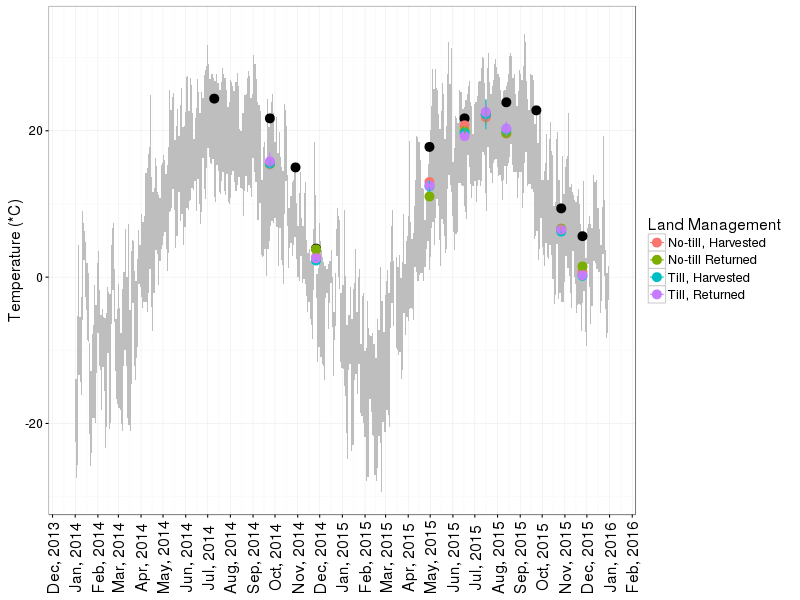

In [23]:
%%R -w 800 -h 600
#rightN = filter(rightN, precip >0)

timelist = c('2014-07-10', '2014-09-24','2014-10-29','2014-11-26','2015-04-30','2015-06-17','2015-07-16',
               '2015-08-13','2015-09-23', '2015-10-27', '2015-11-25')
date.range = as.POSIXct(strptime(timelist, format = "%Y-%m-%d"))

p = ggplot() + geom_ribbon(data = rightN, aes(x = d, ymin = TMIN, ymax = TMAX), fill = "grey") +
    theme_bw() +
    theme(text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.5, size=16)) +
    scale_x_datetime(breaks = date_breaks("1 month"), labels=date_format("%b, %Y")) +
    xlab(NULL) + ylab("Temperature (*C)")  +  
  geom_point(data = subset(rightN, d %in% date.range), aes(x = d, y = TMAX), size = 4, color = 'black') 
    #geom_point(data = subset(rightN, date %in% date.range), aes(date, tmindeg), size = 4, color = 'blue') 

p =  p + 
        geom_point(data = sumdata, aes(x = realdate, y = mean_Soil_Temp, color=Land_Management),size = 4) +
        geom_errorbar(data = sumdata, aes(x = realdate, ymin = ymin_Soil_Temp, ymax = ymax_Soil_Temp,
                                          color = Land_Management), width = 0.2)+
        scale_color_discrete(name = 'Land Management', labels = c('No-till, Harvested', 'No-till Returned',
                                                                              'Till, Harvested', 'Till, Returned')) 
  
p

In [24]:
%%R
ggsave(filename = "data/figs/Soil_Ambient_tempTime.jpg", plot = p, width =8, height =6)

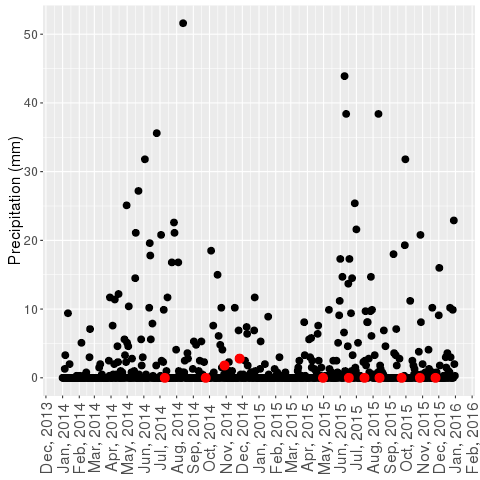

In [27]:
%%R


timelist = c('2014-07-10', '2014-09-24','2014-10-29','2014-11-26','2015-04-30','2015-06-17','2015-07-16',
               '2015-08-13','2015-09-23', '2015-10-27', '2015-11-25')
date.range = as.POSIXct(strptime(timelist, format = "%Y-%m-%d"))
p = ggplot(rightN, aes(d, PRCP)) +
  geom_point(size = 3) +
  theme(
    text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.5, size=16)) +
    scale_x_datetime(breaks = date_breaks("1 month"), labels=date_format("%b, %Y")) +
    xlab(NULL) + ylab("Precipitation (mm)")  +  
  geom_point(data = subset(rightN, d %in% date.range), aes(d, PRCP), size = 4, color = 'red')




p

In [30]:
%%R
ggsave(filename = "data/figs/Precip.jpg", plot = p, width =6.5, height =6)

In [65]:
%%R
library(lubridate)
rightN = mutate(rightN, month = month(d), year = year(d))
head(rightN)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lubridate’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:plyr’:

    here


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:data.table’:

    hour, mday, month, quarter, wday, week, yday, year


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:base’:

    date


  res = super(Function, self).__call__(*new_args, **new_kwargs)


            STATION                            STATION_NAME     DATE MDPR DAPR
1 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140101   NA   NA
2 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140102   NA   NA
3 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140103   NA   NA
4 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140104   NA   NA
5 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140105   NA   NA
6 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140106   NA   NA
  PRCP SNWD SNOW  TMAX  TMIN TOBS WESD WESF WT09 WT01 WT06 WT02 WT08 WT03
1  0.0    0   NA  -9.3 -21.0   NA   NA   NA   NA   NA   NA   NA   NA   NA
2  0.0    0   NA -21.0 -24.9   NA   NA   NA   NA   NA   NA   NA    1   NA
3  0.0    0   NA -18.2 -28.2   NA   NA   NA   NA   NA   NA   NA    1   NA
4  0.0    0    0  -6.0 -28.2   NA   NA   NA   NA   NA   NA   NA   NA   NA
5  1.3    0   NA  -0.5  -9.3   NA   NA   NA   NA    1    1   NA   NA   NA
6  

In [66]:
%%R
rightN$MY = paste(rightN$month, rightN$year, sep = '-')
head(rightN)

            STATION                            STATION_NAME     DATE MDPR DAPR
1 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140101   NA   NA
2 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140102   NA   NA
3 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140103   NA   NA
4 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140104   NA   NA
5 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140105   NA   NA
6 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140106   NA   NA
  PRCP SNWD SNOW  TMAX  TMIN TOBS WESD WESF WT09 WT01 WT06 WT02 WT08 WT03
1  0.0    0   NA  -9.3 -21.0   NA   NA   NA   NA   NA   NA   NA   NA   NA
2  0.0    0   NA -21.0 -24.9   NA   NA   NA   NA   NA   NA   NA    1   NA
3  0.0    0   NA -18.2 -28.2   NA   NA   NA   NA   NA   NA   NA    1   NA
4  0.0    0    0  -6.0 -28.2   NA   NA   NA   NA   NA   NA   NA   NA   NA
5  1.3    0   NA  -0.5  -9.3   NA   NA   NA   NA    1    1   NA   NA   NA
6  

In [67]:
%%R
t.test(rightN$PRCP ~ rightN$year)


	Welch Two Sample t-test

data:  rightN$PRCP by rightN$year
t = -0.2337, df = 728, p-value = 0.8153
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.8962713  0.7055863
sample estimates:
mean in group 2014 mean in group 2015 
          1.962740           2.058082 



In [69]:
%%R
t.test(rightN$TMAX ~ rightN$year)


	Welch Two Sample t-test

data:  rightN$TMAX by rightN$year
t = -1.0432, df = 726.27, p-value = 0.2972
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.6814038  0.8205367
sample estimates:
mean in group 2014 mean in group 2015 
          12.07781           13.00824 



In [ ]:
%%R
t.test(rightN$TMIN ~ rightN$year)

In [ ]:
%%R
aov.PRCP.month = aov(rightN$PRCP ~ rightN$month)
summary(aov.PRCP.month)

In [ ]:
%%R
aov.PRCP.MY = aov(rightN$PRCP ~ rightN$MY)
summary(aov.PRCP.MY)

In [ ]:
%%R
THSD.MY = TukeyHSD(aov.PRCP.MY)
THSD.MY.df = as.data.frame(as.matrix(THSD.MY$`rightN$MY`))
THSD.MY.df$MYcomp = rownames(THSD.MY.df)
THSD.MY.sig = filter(THSD.MY.df, `p adj` <=0.05)

In [ ]:
%%R
THSD.MY.sig$`p adj` %>% as.data.frame

In [ ]:
%%R
THSD.MY.sig

In [ ]:
%%R
ggsave(filename = "data/figs/Precip.jpg", plot = p, width =6, height =6)

In [ ]:
%%R
head(sumdata)

## Soil C and N

In [5]:
%%R
Soil_CN = read.csv('/home/chantal/Chazy/data/Chazy_CN.csv', header = TRUE)
head(Soil_CN)

  Sample.ID weight position   method  X      N.       C. Analysis.time   N.area
1     Blank 1.0000      A01 Soil New NA 0.02818  0.01297           400  17.6580
2     Blank 1.0000      A02 Soil New NA 0.00702  0.02184           401   7.9242
3     Blank 1.0000      A03 Soil New NA 0.00568  0.00640           401   7.2496
4     Blank 1.0000      A04 Soil New NA 0.00592  0.01163           401   7.3708
5     Blank 1.0000      A05 Soil New NA 0.00317  0.00689           401   5.9862
6      EDTA 0.1541      A06 Soil New NA 9.58050 40.94400           401 748.9300
  Experiment X.1    C.area   Date...Time
1       <NA>  NA    466.89  3/24/16 9:21
2       <NA>  NA    753.01  3/24/16 9:28
3       <NA>  NA    398.39  3/24/16 9:35
4       <NA>  NA    518.55  3/24/16 9:58
5       <NA>  NA    409.68 3/24/16 10:05
6       <NA>  NA 143909.00 3/24/16 10:16


In [6]:
%%R
Soil.Chazy = filter(Soil_CN, Experiment == 'Chazy')
head(Soil.Chazy)

  Sample.ID weight position   method  X      N.     C. Analysis.time N.area
1  PTH.4_R1 0.4033      B04 Soil New NA 0.10292 1.6371           401 25.323
2  PTH.4_R2 0.4032      B05 Soil New NA 0.10502 1.6505           402 25.745
3  NTH.1_R1 0.4021      B06 Soil New NA 0.19179 2.1681           402 43.282
4  NTH.1_R2 0.4026      B07 Soil New NA 0.18773 2.1609           402 42.506
5     NTH.2 0.4037      B08 Soil New NA 0.15485 1.8189           402 35.916
6     NTH.3 0.4068      B09 Soil New NA 0.23632 2.6759           402 52.872
  Experiment X.1 C.area   Date...Time
1      Chazy  NA  15547 3/24/16 11:26
2      Chazy  NA  15669 3/24/16 11:33
3      Chazy  NA  20435 3/24/16 11:40
4      Chazy  NA  20393 3/24/16 11:47
5      Chazy  NA  17259 3/24/16 11:54
6      Chazy  NA  25436 3/24/16 12:01


In [25]:
%%R
Soil.sum = Soil.Chazy %>% separate(Sample.ID, c('Treatment', 'Rep', 'rerun')) 

Soil.sum$Till[Soil.sum$Treatment %in% c('PTH', 'PTR')] = "Till"
Soil.sum$Till[Soil.sum$Treatment %in% c('NTH', 'NTR')] = "No-till"
Soil.sum$OM[Soil.sum$Treatment %in% c('PTH', 'NTH')] = "Harvested"
Soil.sum$OM[Soil.sum$Treatment %in% c('NTR', 'PTR')] = "Returned"


Soil.sum = filter(Soil.sum, !(position %in% c('B05', 'B07')))
Soil.sum$C_N = Soil.sum$C./Soil.sum$N.
head(Soil.sum)

  Treatment Rep rerun weight position   method  X      N.     C. Analysis.time
1       PTH   4    R1 0.4033      B04 Soil New NA 0.10292 1.6371           401
2       NTH   1    R1 0.4021      B06 Soil New NA 0.19179 2.1681           402
3       NTH   2  <NA> 0.4037      B08 Soil New NA 0.15485 1.8189           402
4       NTH   3  <NA> 0.4068      B09 Soil New NA 0.23632 2.6759           402
5       NTR   3  <NA> 0.3997      B10 Soil New NA 0.25502 3.2604           402
6       NTR   2  <NA> 0.4032      C01 Soil New NA 0.19892 2.2323           402
  N.area Experiment X.1 C.area   Date...Time    Till        OM      C_N
1 25.323      Chazy  NA  15547 3/24/16 11:26    Till Harvested 15.90653
2 43.282      Chazy  NA  20435 3/24/16 11:40 No-till Harvested 11.30455
3 35.916      Chazy  NA  17259 3/24/16 11:54 No-till Harvested 11.74621
4 52.872      Chazy  NA  25436 3/24/16 12:01 No-till Harvested 11.32321
5 55.795      Chazy  NA  30382 3/24/16 12:08 No-till  Returned 12.78488
6 44.838      C

In [8]:
%%R
Soil.summary = Soil.sum %>% group_by(Treatment) %>% summarise(meanC = mean(C.), sdC = sd(C.), meanN = mean(N.), 
                                                              sdN = sd(N.), meanCN = mean(C_N), sdCN = sd(C_N))

Soil.summary

Source: local data frame [4 x 7]

  Treatment    meanC       sdC     meanN        sdN   meanCN      sdCN
      (chr)    (dbl)     (dbl)     (dbl)      (dbl)    (dbl)     (dbl)
1       NTH 2.134525 0.3920386 0.1849525 0.03821554 11.58233 0.3216215
2       NTR 2.765900 0.4781857 0.2256975 0.02872859 12.20398 0.6814242
3       PTH 1.498750 0.2574017 0.1048525 0.02089946 14.36416 1.1244099
4       PTR 1.617825 0.3989296 0.1116400 0.01222949 14.35761 2.0218952


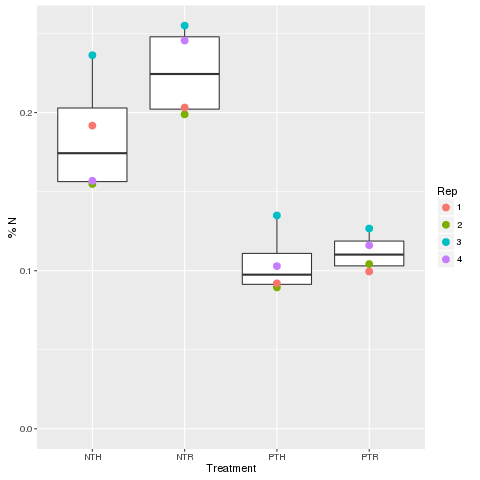

In [9]:
%%R
p = ggplot(Soil.sum, aes(x = Treatment, y = N.)) + 
    geom_boxplot() + geom_point(aes(color = Rep), size = 3) + ylab("% N") + expand_limits(y=0)
p

In [27]:
%%R
av = aov(lm(Soil.sum$N. ~ Soil.sum$Till * Soil.sum$OM + Soil.sum$Rep))
summary(av)

                          Df  Sum Sq Mean Sq F value   Pr(>F)    
Soil.sum$Till              1 0.03770 0.03770 127.951 1.27e-06 ***
Soil.sum$OM                1 0.00226 0.00226   7.669   0.0218 *  
Soil.sum$Rep               3 0.00596 0.00199   6.748   0.0111 *  
Soil.sum$Till:Soil.sum$OM  1 0.00115 0.00115   3.914   0.0793 .  
Residuals                  9 0.00265 0.00029                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
%%R
av = aov(lm(Soil.sum$C. ~ Soil.sum$Till * Soil.sum$OM + Soil.sum$Rep))
summary(av)

                          Df Sum Sq Mean Sq F value   Pr(>F)    
Soil.sum$Till              1  3.182   3.182   77.23 1.04e-05 ***
Soil.sum$OM                1  0.563   0.563   13.67  0.00494 ** 
Soil.sum$Rep               3  1.452   0.484   11.75  0.00182 ** 
Soil.sum$Till:Soil.sum$OM  1  0.262   0.262    6.37  0.03256 *  
Residuals                  9  0.371   0.041                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [31]:
%%R
av = aov(lm(Soil.sum$C_N ~ Soil.sum$Till * Soil.sum$OM + Soil.sum$Rep))
summary(av)

                          Df Sum Sq Mean Sq F value Pr(>F)   
Soil.sum$Till              1 24.359  24.359  14.698  0.004 **
Soil.sum$OM                1  0.378   0.378   0.228  0.644   
Soil.sum$Rep               3  2.845   0.948   0.572  0.647   
Soil.sum$Till:Soil.sum$OM  1  0.395   0.395   0.238  0.637   
Residuals                  9 14.916   1.657                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [34]:
%%R
Soil.sum = Soil.sum %>% arrange(Treatment, Rep)
head(Soil.sum)

  Treatment Rep rerun weight position   method  X      N.     C. Analysis.time
1       NTH   1    R1 0.4021      B06 Soil New NA 0.19179 2.1681           402
2       NTH   2  <NA> 0.4037      B08 Soil New NA 0.15485 1.8189           402
3       NTH   3  <NA> 0.4068      B09 Soil New NA 0.23632 2.6759           402
4       NTH   4  <NA> 0.4042      C04 Soil New NA 0.15685 1.8752           402
5       NTR   1  <NA> 0.4056      C06 Soil New NA 0.20326 2.5062           402
6       NTR   2  <NA> 0.4032      C01 Soil New NA 0.19892 2.2323           402
  N.area Experiment X.1 C.area   Date...Time    Till        OM      C_N
1 43.282      Chazy  NA  20435 3/24/16 11:40 No-till Harvested 11.30455
2 35.916      Chazy  NA  17259 3/24/16 11:54 No-till Harvested 11.74621
3 52.872      Chazy  NA  25436 3/24/16 12:01 No-till Harvested 11.32321
4 36.362      Chazy  NA  17806 3/24/16 12:36 No-till Harvested 11.95537
5 45.966      Chazy  NA  23775 3/24/16 12:51 No-till  Returned 12.33002
6 44.838      C

In [35]:
%%R
pairwise.t.test(Soil.sum$N.,Soil.sum$Treatment, p.adjust.method = 'BH',
                 paired = TRUE)


	Pairwise comparisons using paired t tests 

data:  Soil.sum$N. and Soil.sum$Treatment 

    NTH    NTR    PTH   
NTR 0.1222 -      -     
PTH 0.0139 0.0029 -     
PTR 0.0316 0.0029 0.2869

P value adjustment method: BH 


In [36]:
%%R
pairwise.t.test(Soil.sum$C.,Soil.sum$Treatment, p.adjust.method = 'BH',
                 paired = TRUE)


	Pairwise comparisons using paired t tests 

data:  Soil.sum$C. and Soil.sum$Treatment 

    NTH    NTR    PTH   
NTR 0.0561 -      -     
PTH 0.0359 0.0091 -     
PTR 0.0359 0.0148 0.3765

P value adjustment method: BH 


In [37]:
%%R
pairwise.t.test(Soil.sum$C_N,Soil.sum$Treatment, p.adjust.method = 'BH',
                 paired = TRUE)


	Pairwise comparisons using paired t tests 

data:  Soil.sum$C_N and Soil.sum$Treatment 

    NTH   NTR   PTH  
NTR 0.290 -     -    
PTH 0.054 0.124 -    
PTR 0.149 0.149 0.997

P value adjustment method: BH 


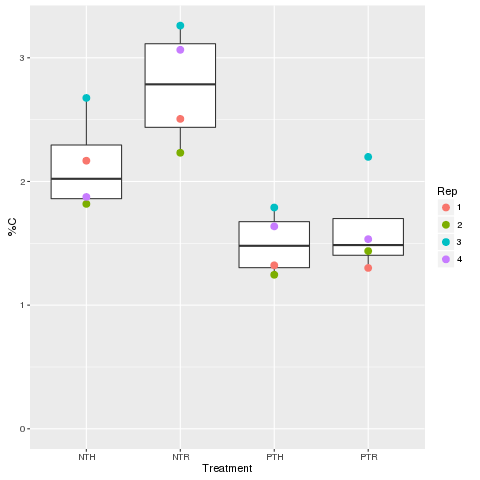

In [13]:
%%R
p = ggplot(Soil.sum, aes(x = Treatment, y = C.)) + 
    geom_boxplot() + geom_point(aes(color = Rep), size = 3) + ylab('%C') + expand_limits(y=0)
p

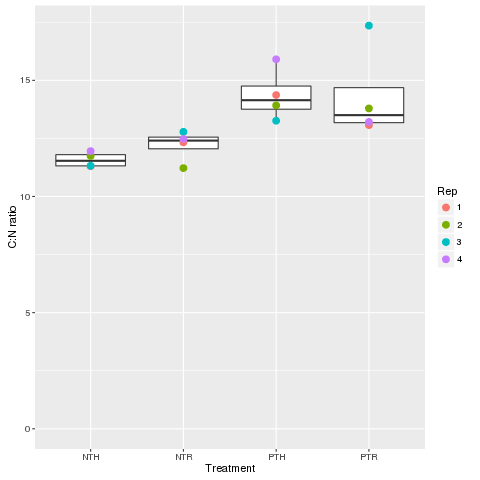

In [16]:
%%R
p = ggplot(Soil.sum, aes(x = Treatment, y = C_N)) + 
    geom_boxplot() + geom_point(aes(color = Rep), size = 3) + ylab('C:N ratio') + expand_limits(y=0)
p

## pH

In [20]:
%%R
pH = read.csv('data/pH_ChazySept2014.csv')

In [21]:
%%R
head(pH)

     X  pH1  pH2   Avg         SD Treatment Rep
1 NTH1 7.15 7.33 7.240 0.12727922       NTH   1
2 NTH2 7.30 7.28 7.290 0.01414214       NTH   2
3 NTH3 5.45 5.48 5.465 0.02121320       NTH   3
4 NTH4 7.41 7.50 7.455 0.06363961       NTH   4
5 NTR1 7.37 7.31 7.340 0.04242641       NTR   1
6 NTR2 5.93 5.90 5.915 0.02121320       NTR   2


In [22]:
%%R
head(pH) 
pH %>% group_by(Treatment) %>% summarize(meanpH = mean(Avg), sdpH = sd(Avg))

Source: local data frame [4 x 3]

  Treatment  meanpH       sdpH
     (fctr)   (dbl)      (dbl)
1       NTH 6.86250 0.93618463
2       NTR 6.88625 0.67609633
3       PTH 7.74375 0.06956711
4       PTR 7.65500 0.04966555


In [23]:
%%R
av = aov(pH$Avg ~ pH$Treatment + pH$Rep)
summary(av)

             Df Sum Sq Mean Sq F value Pr(>F)
pH$Treatment  3  2.739  0.9131   2.499  0.114
pH$Rep        1  0.003  0.0028   0.008  0.932
Residuals    11  4.020  0.3654               


In [24]:
%%R
pairwise.t.test(pH$Avg,pH$Treatment, p.adjust.method = 'BH',
                 paired = TRUE)


	Pairwise comparisons using paired t tests 

data:  pH$Avg and pH$Treatment 

    NTH  NTR  PTH 
NTR 0.97 -    -   
PTH 0.23 0.23 -   
PTR 0.23 0.23 0.23

P value adjustment method: BH 
